![alt text](DataKind_orange.png)

  # Omidyar Extractives Project 1
## Extract Contract Text
### Hash-based partitition function for segmenting documents prior to clustering

In [1]:
from lib.py_rabin import rabin_partition, example_rabin_partition
import re
import time
import subprocess
import itertools
import cPickle as pickle
import numpy as np
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as hcluster
import pandas as pd
import collections as cl
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
from IPython.core.debugger import Tracer
import pprint
pp = pprint.PrettyPrinter(indent=2)
%load_ext cythonmagic
%load_ext line_profiler

/Users/ivlahinic/anaconda2/lib/python2.7/site-packages/IPython/extensions/cythonmagic.py:21: UserWarning: The Cython magic has been moved to the Cython package
  warnings.warn("""The Cython magic has been moved to the Cython package""")


### import and clean documents 

In [2]:
# remove other characters
char_to_remove = set(['.',',',';',':','-','_','[',']','&','`','@','*','^','|','~',';',':','\'','\"',">","<"]) 
def longstr_clean(longstr):
    longstr = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]', '', longstr) # remove all non-printable characters
    longstr = re.compile(r'<.*?>').sub('', longstr) # strip html markup, e.g. <br>,<div>, etc...
    longstr = longstr.replace("&nbsp",'').replace("&lt;",'').replace("&gt;",'').replace("\\","") 
    longstr = "".join(i for i in longstr if ord(i)<128 and i not in char_to_remove)
    longstr = longstr.replace('\r','').replace('\n','').replace('\t','')
    longstr = " ".join(longstr.split()).lower() # remove whitespace
    return longstr

In [3]:
start = time.time()
#df = pd.read_pickle('contract_data/openland_contracts_with_text.pkl') # ~200 
df = pd.read_pickle('contract_data/resource_contracts_with_text.pkl') # ~1500
df.columns = [k.lower().replace(" ","_") for k in df.columns]
print('Time to load documents: %s seconds' % str(time.time()-start) )


# ## uncomment for training
# df = df.iloc[:100]
# ##

df["contract_text_clean"] = df.contract_text.apply(longstr_clean) 
print('Time to clean document text: %s seconds' % str(time.time()-start) )

print('\nTotal documents: %d' % len(df))
df.columns

Time to load documents: 0.787400007248 seconds
Time to clean document text: 158.05419302 seconds

Total documents: 1496


Index([u'ocid', u'category', u'contract_name', u'contract_identifier',
       u'language', u'country_name', u'resource', u'contract_type',
       u'signature_date', u'document_type', u'government_entity',
       u'government_identifier', u'company_name', u'company_address',
       u'jurisdiction_of_incorporation', u'registration_agency',
       u'company_number', u'corporate_grouping', u'participation_share',
       u'open_corporates_link', u'incorporation_date', u'operator',
       u'project_title', u'project_identifier', u'license_name',
       u'license_identifier', u'source_url', u'disclosure_mode',
       u'retrieval_date', u'pdf_url', u'deal_number', u'contract_note',
       u'matrix_page', u'annotation_category', u'annotation_text',
       u'contract_text', u'contract_text_clean'],
      dtype='object')

### create document network
#### node = document; edge = document distance or similarity based on rabin fingerprints

In [4]:
def rabin_graph(seriesDocs, paramRabin, flag="char"):
    """
    Cpu and memory optimized optimized graph construction
    
    :param serisDf: pandas series documents    
    :param indexDf: pandas series index (default: range(len(series(df))))
    :param paramRabin: 
    :param flag: similarity metric (default: fraction of text in common)
    
    :return G: NetworkX undirected graph (nodes=docs, edges=doc similarity)   
    """
    pass

fpraw = '_docRabinChunks'
fpsorted = '_docRabinChunks_sorted'
paramRabin = {"avgchunk":16, "minchunk":8, "maxchunk":32, "windowsize":8, "windowslide":1} 
flag="char"

# ----------------------------------
# CREATE GRAPH NODES AND BREAK UP DOCUMENTS INTO RABIN CHUNKS
# 1. identify chunks via 'rabin fingerprint', and w
# 2. break up file marker-2-marker and sort by docFingerprint
start = time.time()
G = nx.Graph() 
with open(fpraw,'w') as fp:
    for k in xrange(len(df.index)):
        a = df.contract_text_clean.iloc[k]   # retrieve document text (must be clean already)
        if len(a) <= 10:  continue
        b = rabin_partition(a,**paramRabin)  # partition document via rabin fingerprint
        c = set(b)

        # add node to graph; 
        # also store document id, unique chunks, character length of unique chunks
        G.add_node(k,
                   ocid = df.ocid.iloc[k],
                   n_chunk = len(c),
                   n_char  = sum([len(i) for i in c]))
        fp.writelines([str(i)+'|'+str(k)+'\n' for i in c])
print('Rabin chunks identified: %s seconds' % str(time.time()-start) )

# ----------------------------------
# in-memory pre-sort for all document chunks for speed up many-many comparison (O(n^2))
cmd = 'sort -k1 -S2G ' + fpraw + ' > ' + fpsorted
subprocess.call(cmd,shell=True)
print('Rabin chunks sorted: %s seconds' % str(time.time()-start) )

# ----------------------------------
# UPDATE GRAPH WITH EDGE WEIGHTS = node similarity
with open(fpsorted,'r') as fp:
    # read line by line
    for ix,line in enumerate(fp):
        chunk,k = line.strip('\n').split('|')
        if ix==0: tmp=[]; prev_chunk = chunk

        # collect docs that share the same chunk (recall: chunks are sorted)
        if len(prev_chunk) == len(chunk) and prev_chunk == chunk:
            tmp.extend([int(k)])

        # complete edge comparison, i.e.common chunks between document pairs    
        else:
            if len(tmp)>1:
                lenchunk = float(len(prev_chunk))
                for (m,n) in itertools.combinations(tmp,2):
                    if not G.has_edge(m,n): 
                        G.add_edge(m, n, n_chunk_matched=0., n_char_matched=0.)
                    G[m][n]['n_chunk_matched'] += 1. 
                    G[m][n]['n_char_matched']  += lenchunk
            tmp=[int(k)]
        prev_chunk = chunk 

    # compute weights for all edges based on jaccard distance = len(shared text) / len(shorter document) 
    for m,n in G.edges_iter():
        if flag == "char":
            G[m][n]["weight"] = G[m][n]["n_char_matched"] / min(G.node[m]['n_char'],G.node[n]['n_char']) 
        elif flag == "chunk":
            G[m][n]["weight"] = G[m][n]["n_chunk_matched"] / min(G.node[m]['n_chunk'],G.node[n]['n_chunk']) 
        else:
            assert True # No such distance metric is available

# clean up tmp files 
cmd = 'rm '+fpraw+' && '+'rm '+fpsorted
subprocess.call(cmd,shell=True)
print('Documents compared for similarity: %s seconds'%str(time.time()-start))

Rabin chunks identified: 144.875282049 seconds
Rabin chunks sorted: 357.939395189 seconds
Documents compared for similarity: 524.285878181 seconds


### trim network and identify oneoff documents 

In [5]:
def identifyIsolates(G):
    """Identify isolated nodes, i.e. nodes not connected to any other"""
    iso = nx.isolates(G)
    return iso if len(iso)>0 else None 
def clipEdges(G,minWeight=0.01):
    """Clip weakly connected edges"""
    if minWeight:
        print('\nClipped edges less than weight: %f' % minWeight )
        H = G.copy()
        H.remove_edges_from([(u,v) for (u,v,d) in H.edges(data=True) if d['weight'] < minWeight])
    return H if minWeight else G  

# clip weak edges
G = clipEdges(G,minWeight=0.01)

# remove one-off documents (those not connected to any other)
oneoffs  = identifyIsolates(G)        # identify isolated docs
if oneoffs:
    Goneoffs = nx.subgraph(G,oneoffs) # keep info in a separate graph
    G.remove_nodes_from(oneoffs)      # remove oneoffs from the main network
    print("\nNumber of 'oneoff' documents: %d"%len(oneoffs))

# Graph summary
print('\nGraph/network summary:')
print nx.info(G)
print('Average density: %f' % nx.density(G))


Clipped edges at Applied min similarity threshold: 0.010000

Number of 'oneoff' documents: 15

Graph/network summary:
Name: 
Type: Graph
Number of nodes: 1480
Number of edges: 143469
Average degree: 193.8770
Average density: 0.131087


### visualize corpus via ward hierarchical clustering 

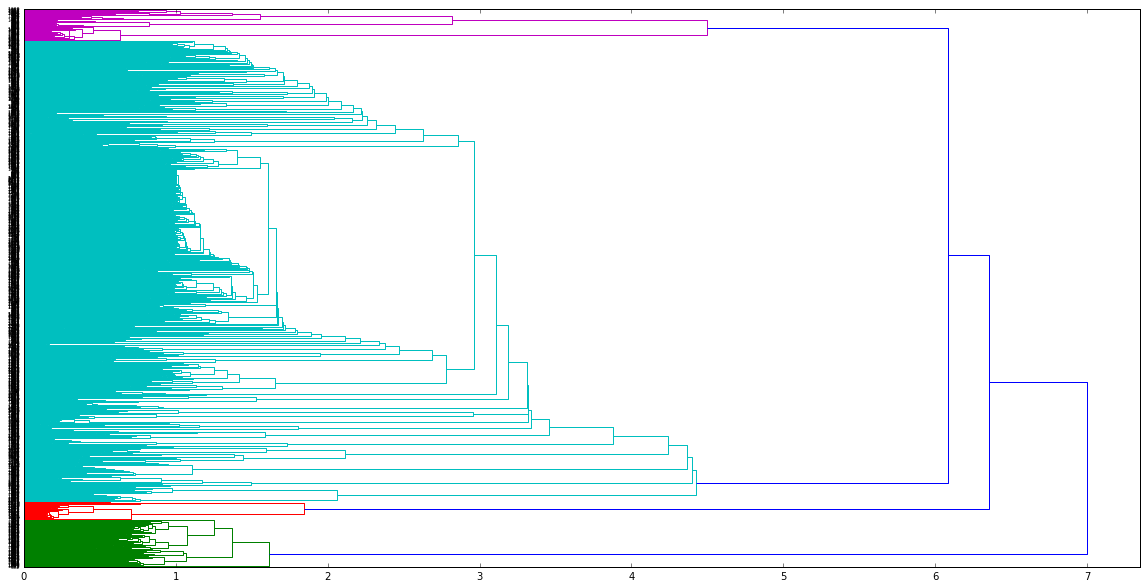

In [6]:
## classic *ward* hierarchical clustering 
k = 0
N = len(G.nodes())
dMatrix = np.zeros([N*(N-1)/2,1])
for m in G.nodes():
    for n in G.nodes():
        if n>m:
            #if G.has_edge(m,n) and G[m][n]["weight"] > 0.95: print m,n,G[m][n]["weight"]             
            dMatrix[k,0] = 1. - G[m][n]["weight"] if G.has_edge(m,n) else 1.
            k+=1
dMatrix = dMatrix.flatten()
linkage = hcluster.ward(dMatrix)
dendro  = hcluster.dendrogram(linkage,orientation='right')

### identify templates via louvain clustering

In [7]:
def merge_two_dicts(x, y):
    """Given two dicts, merge them into a new dict as a shallow copy"""
    z = x.copy()
    z.update(y)
    return z

def louvain(G,labelBase=None):
    """
    Hierchical clustering algorithm. Best-in-class winner 2010 
    ref: V.D. Blondel, J.-L. Guillaume, R. Lambiotte, E. Lefebvre. 
         "Fast unfolding of communities in large networks." J. Stat. Mech., 2008: 1008
    
    :param G: NetworkX undirected graph contaning nodes, edges, and edge weights
    :param labelBase: used to convert default 0,1,2... to labelBase.0, labelBase.1, etc... 
    :return D: ordered dictionary containing cluster labels and G.nodes() belonging to each cluster 
    """
    import community as cm
    D=cl.OrderedDict()
    p=cm.best_partition(G)
    for label in set(p.values()):
        newlabel = str(labelBase)+"."+str(int(label)) if labelBase else str(int(label))
        D[newlabel] = sorted([k for k in p.keys() if p[k] == label])
    return D

def recursive_louvain(G,maxLevel=10):
    """
    Recursive wrapper for lovain clustering algorithm
    
    :param G: symmetric networkx graph containg nodes, edges, and edge weights
    :param maxLevel: max recursive depth  
    :return D: ordered dictionary containing cluster labels and G.nodes() belonging to each cluster 
    """
    start = time.time()
    D = cl.OrderedDict()
    for k in xrange(maxLevel):
        prev_level = "Level_%02d"%(k-1)
        next_level = "Level_%02d"%(k)
        d=cl.OrderedDict()  
        # level zero
        if k==0: 
            D[next_level] = louvain(G)
        
        # level 1+
        else: 
            # loop through all clusters at previous level
            for key,val in D[prev_level].iteritems():
                d2 = louvain(G.subgraph(val),key)
                if len(d2.keys())==1: 
                    d = merge_two_dicts(d,{key:val})
                else:
                    d = merge_two_dicts(d,d2)
            
            # check if max depth is reached / further partition is possible
            if len(d.keys()) > len(D[prev_level].keys()) and k<maxLevel:
                D[next_level] = d.copy()
            else:
                print('Max cluster depth: %s'%prev_level)
                print('Time to complete recursive louvain: %s seconds'%str(time.time()-start))
                break
    return D

In [8]:
D = recursive_louvain(G)

Max cluster depth: Level_06
Time to complete recursive louvain: 17.5690710545 seconds


### Export to csv 

In [11]:
pd.options.mode.chained_assignment = None  # default='warn'

# prepare for csv output
df2 = df[["ocid"]].copy()
for level in D.keys():
    df2[level] = None
    for key,val in D[level].iteritems():
        df2[level].iloc[val] = key
df2.head(25)

,ocid,Level_00,Level_01,Level_02,Level_03,Level_04,Level_05,Level_06
0,ocds-591adf-3757991515,0,0.0,0.0.0,0.0.0.0,0.0.0.0.0,0.0.0.0.0.0,0.0.0.0.0.0
1,ocds-591adf-4472360738,0,0.0,0.0.0,0.0.0.0,0.0.0.0.0,0.0.0.0.0.1,0.0.0.0.0.1
2,ocds-591adf-6005604716,0,0.1,0.1.0,0.1.0.0,0.1.0.0.0,0.1.0.0.0,0.1.0.0.0
3,ocds-591adf-0929569171,0,0.0,0.0.1,0.0.1.0,0.0.1.0.0,0.0.1.0.0,0.0.1.0.0
4,ocds-591adf-1835848694,0,0.0,0.0.2,0.0.2,0.0.2,0.0.2,0.0.2
5,ocds-591adf-4977579802,0,0.0,0.0.3,0.0.3.0,0.0.3.0,0.0.3.0,0.0.3.0
6,ocds-591adf-3212507685,0,0.0,0.0.0,0.0.0.0,0.0.0.0.2,0.0.0.0.2.0,0.0.0.0.2.0
7,ocds-591adf-5978990122,1,1.0,1.0.0,1.0.0,1.0.0,1.0.0,1.0.0
8,ocds-591adf-8201633114,1,1.0,1.0.1,1.0.1,1.0.1,1.0.1,1.0.1
9,ocds-591adf-0075411163,0,0.0,0.0.0,0.0.0.0,0.0.0.0.2,0.0.0.0.2.2,0.0.0.0.2.2.1


In [13]:
df2.to_csv("resource_contracts_with_text_templates.csv")

### spot check templates

In [40]:
# REFERENCE: "resource_contracts_with_text_templates.csv"  in home directory
ix1,ix2 = 662,1209  # cluster 14
ix1,ix2 = 296,305   # cluster 13
ix1,ix2 = 296,1285  # cluster 13

In [41]:
# document similarity: fuzzy match
from fuzzywuzzy import fuzz
longstr1 = df.contract_text_clean.iloc[ix1]
longstr2 = df.contract_text_clean.iloc[ix2]
print "fuzzy-match similarity: %d%%"%fuzz.ratio(longstr1, longstr2)

# document similarity: tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer().fit_transform([longstr1,longstr2])
pairwise_similarity = tfidf * tfidf.T
print "tf-idf similarity: %d%%"%(100.*pairwise_similarity[(0,1)])

fuzzy match similarity: 87%
tf-idf similarity: 99%


In [42]:
longstr1 

'contrato de concesso para pesquisa e produoentreo governo da repblica de moambiqueepcmozambique (rovuma basin) ltdeempresa nacional de hidrocarbonetos empresapblica paraas reas offshore 3 6 da bacia de rovuma repblica de moambiqueexecution copy 10/10/2008inp instituto nacional de petrleorepblica de moambiquendiceartigo assunto pgina partes 1 prembulo 21 documentos contratuais 32 definies 43 direitos contratuais e sua durao 94 obrigaes de trabalho durante o perodo de pesquisa 135 conduo das operaes petrolferas 206 descoberta comercial e desenvolvimento 227 abandono de reas 248 registos e relatrios 259 recuperao de custos e direito produo 2710 determinao do valor do petrleo 3411 termos fiscais e outros encargos 3812 bnus de produo 4813 regras sobre o levantamento 4914 conservao do petrleo e preveno de perdas 5015 desmobilizao 5216 seguros 5517 gs natural 5818 emprego e formao 6219 indemnizaes e responsabilidade 6420 titularidade 6621 direitos de inspeco 6722 contabilidade e auditorias 6

In [43]:
longstr2

'contrato de concesso para pesquisa e produoentreo governo da repblica de moambiqueesasol petroleum mozambique exploration limitadaeempresa nacional de hidrocarbonetos empresa pblicapararea a onshore repblica de moambique repblica de moambique ministrio das finanas cartrio notarial privativo termo de autenticao no dia trs de maro de dois mil e onze nesta cidade de maputo eno cartrio notarial privativo do ministrio das finanas perante mimisaas simio siti licenciado em direito e notrio do referido cartriocompareceram como outorgantes o governo da republica de moambique representado por suaexcelncia a ministra dos recursos minerais senhora esperanalaurinda francisco nhiuane bias a sasol petroleium mozambique exploration limitada umasociedade constituda e regida pela lei moambicana representadopelo senhor engelbert abraham haam na sua qualidade de directorgeral a empresa nacional de hidrocarbonetos ep uma sociedadeconstituda e regida pela lei moambicana representada pelo senhornelson arnal

### reference code --------------------------- 

In [ ]:

longstr1 = df.iloc[5].contract_text_clean
longstr2 = df.iloc[14].contract_text_clean


In [ ]:
minchunk,avgchunk,maxchunk=32,64,128
a = set(rabin_partition(longstr1,avgchunk,minchunk,maxchunk,32))
b = set(rabin_partition(longstr2,avgchunk,minchunk,maxchunk,32))

print
print "EXAMPLE USE CASE: DOCUMENT SIMILARITY"
print

print
print "Percent similarity between document 1 and 2: \n%0.2f%%"%( 100.*len(a&b)/float(min(len(a),len(b))) )

print
print "Common rabin chunks between documents 1 and 2:"
print [k for k in rabin_partition(longstr1) if k in set(rabin_partition(longstr2))]

print
print "Non-common rabin chunks between document 1 and 2:"
print [k for k in rabin_partition(longstr1) if k not in set(rabin_partition(longstr2))]
print

In [ ]:
# clustering based on connected components
def find_cluster_cutoff(G, cutoff = 0.10, minCluster=0):
    print('\nSimilarity cutoff: %f' % cutoff )
    H = G.copy()
    H.remove_edges_from([(u,v) for (u,v,d) in H.edges(data=True) if d['weight'] < cutoff])
    clusters = [sorted(i) for i in sorted(nx.connected_components(H),key=len,reverse=True) if len(i)>minCluster]
    print_cluster_summary(G,clusters)
    return clusters

# summary of cluster results
def print_cluster_summary(G,clusters):
    print('\nNumber of clusters identified: %d' % len(clusters))
    print('Document coverage: %d%% (%d of %d)' % \
          (100 * sum([len(i) for i in clusters])/len(G.node), sum([len(i) for i in clusters]), len(G.node)))
    print('\nCluster sizes:')
    print([len(i) for i in clusters])

# clustering based on lovain method 
def find_cluster_louvain(G,minCluster=0):
    partition = cm.best_partition(G)
    clusters = []
    for label in set(partition.values()):
        clusters.append([i for i in partition.keys() if partition[i] == label])
    clusters = [sorted(i) for i in sorted(clusters, key = len, reverse=True) if len(i)>minCluster]
    print_cluster_summary(G,clusters)
    return clusters

# collect output
def base_output(G,node,label):
    doc_id     = G.node[node]['ocid']
    doc_degree = G.degree(node) 
    return [doc_id,label,doc_degree]